# Analysis of Service BC Centre Data

This report provides an analysis of data from Service BC centres, including service volumes, transaction durations, and service centre locations. Additional data from the Statistics Canada, BC government on population demographics and urban/rural splits are also incorporated to provide a comprehensive view of the services.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
import inflection
import missingno as msno
import folium
from wordcloud import WordCloud
import squarify
import os

### Office info dataset cleaning and preprocessing

In [2]:
office_info = pd.read_csv('./data/Office info dataset.csv')

In [3]:
office_info.head()

,OfficeID,OfficeName,City,OfficeSize,Area,AreaName,Address,Latitude,Longitude
0,1,100 Mile House,100 Mile House,MICRO,4.0,Central Peace,300 Hwy 97,51.644455,-121.297478
1,2,Ashcroft,Ashcroft,MICRO,4.0,Interior,318 Railway Ave,50.720196,-121.280960
2,3,Atlin,Atlin,MICRO,1.0,Lower Mainland Capital,100 - 3rd St,59.578030,-133.689529
3,4,Bella Coola,Bella Coola,MICRO,3.0,Lower Mainland Capital,636 Cliff St,52.372311,-126.754929
4,5,Burns Lake,Burns Lake,MICRO,2.0,North Coast,161 Hwy 16,54.225189,-125.755997


In [4]:
print("Office info dataset has {} rows" .format(office_info.shape[0]))
print("Office info dataset has {} columns" .format(office_info.shape[1]))

Office info dataset has 75 rows
Office info dataset has 9 columns


In [5]:
office_info.info() #checking missing data and data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OfficeID    75 non-null     int64  
 1   OfficeName  75 non-null     object 
 2   City        66 non-null     object 
 3   OfficeSize  65 non-null     object 
 4   Area        65 non-null     float64
 5   AreaName    74 non-null     object 
 6   Address     65 non-null     object 
 7   Latitude    65 non-null     float64
 8   Longitude   65 non-null     float64
dtypes: float64(3), int64(1), object(5)
memory usage: 5.4+ KB


In [6]:
office_info.nunique() #count of unique values in each field

OfficeID      75
OfficeName    75
City          66
OfficeSize     4
Area           7
AreaName      10
Address       65
Latitude      65
Longitude     65
dtype: int64

* Let's clean the column names

In [7]:
office_info = office_info.rename(columns=lambda x:inflection.underscore(x))
office_info.columns

Index(['office_id', 'office_name', 'city', 'office_size', 'area', 'area_name',
       'address', 'latitude', 'longitude'],
      dtype='object')

In [8]:
office_info.isnull().sum()

office_id       0
office_name     0
city            9
office_size    10
area           10
area_name       1
address        10
latitude       10
longitude      10
dtype: int64

* There seems to be some null values in the dataset. Let's see if they are imputable or bad data.

In [9]:
null_data = office_info[office_info.isnull().any(axis=1)]
null_data

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
62,94,Test Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,95,Send Video1,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
67,99,Head Office,Head Office,NaN,NaN,Head Office,NaN,NaN,NaN
68,454,Send Video2,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
69,455,Send Video3,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
70,456,Send Video4,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
71,457,Send Video5,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
72,458,Send Video6,NaN,NaN,NaN,Send Video\r\n,NaN,NaN,NaN
73,459,Rapid Response,NaN,NaN,NaN,Rapid Response,NaN,NaN,NaN
74,500,Mobile Outreach,NaN,NaN,NaN,Mobile Outreach,NaN,NaN,NaN


* All the rows with null values in them seem unlrelated to the rest of the data and can be safely dropped.

In [10]:
print("Rows in the office dataset before cleaning: {}".format(office_info.shape[0]))
clean_office = office_info.dropna()
print("Rows in the office dataset after cleaning: {}".format(clean_office.shape[0]))

Rows in the office dataset before cleaning: 75
Rows in the office dataset after cleaning: 65


* A high level observation shows office_name and city have same data, let's check over the whole dataset if this is true. In that case, we can drop one of the columns because it is redudant information.

In [11]:
clean_office[clean_office['office_name']!=clean_office['city']]

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
19,20,Ganges,Salt Spring Island,MICRO,3.0,Lower Mainland Capital,343 Lower Ganges Rd,48.860123,-123.508842
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489


* Suprisingly there are two offices that have a different name than the city name !. So, we cannot drop either columns.

* Let's see where the offices are located and if there is bad data in locations (office outside British Columbia).

In [12]:
#converting pandas dataframe to geodataframe for spatial analysis
geometry = [Point(xy) for xy in zip(clean_office.longitude, clean_office.latitude)]
office_gdf = gpd.GeoDataFrame(clean_office, crs="EPSG:4326", geometry=geometry)

In [13]:
office_gdf.head()

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude,geometry
0,1,100 Mile House,100 Mile House,MICRO,4.0,Central Peace,300 Hwy 97,51.644455,-121.297478,POINT (-121.29748 51.64446)
1,2,Ashcroft,Ashcroft,MICRO,4.0,Interior,318 Railway Ave,50.720196,-121.280960,POINT (-121.28096 50.72020)
2,3,Atlin,Atlin,MICRO,1.0,Lower Mainland Capital,100 - 3rd St,59.578030,-133.689529,POINT (-133.68953 59.57803)
3,4,Bella Coola,Bella Coola,MICRO,3.0,Lower Mainland Capital,636 Cliff St,52.372311,-126.754929,POINT (-126.75493 52.37231)
4,5,Burns Lake,Burns Lake,MICRO,2.0,North Coast,161 Hwy 16,54.225189,-125.755997,POINT (-125.75600 54.22519)


In [14]:
# Path to the shapefile
shapefile_path = './data/location_data/lpr_000b21a_e.shp'

# Read the shapefile into a GeoDataFrame
provinces_gdf = gpd.read_file(shapefile_path)

bc_boundary = provinces_gdf[provinces_gdf['PRENAME'] == 'British Columbia']
bc_boundary

,PRUID,DGUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,LANDAREA,geometry
9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544,"MULTIPOLYGON (((3843551.097 2389750.100, 38435..."


* The following cell is a complex visualization and can take upto 10 min to finish.

In [15]:
output_file = './output/office_locations.html'

# Check if the file exists
if not os.path.isfile(output_file):
    # If the file does not exist, run the code to generate it
    print("File does not exist, generating HTML...")
    # Create a folium map centered around British Columbia
    bc_map = folium.Map(location=[53.7267, -127.6476], zoom_start=6)

    # Add the BC boundary to the map
    folium.GeoJson(bc_boundary).add_to(bc_map)

    # Iterate over the office locations GeoDataFrame
    for idx, row in office_gdf.iterrows():
        # Extract the latitude and longitude from the office location geometry
        lon, lat = row.geometry.coords[0]
        
        # Create a marker for each office location and add it to the map
        marker = folium.Marker(location=[lat, lon])

        # Create a tooltip with the city name
        tooltip = folium.Tooltip(text=row['city'])
        
        # Add the tooltip to the marker
        marker.add_child(tooltip)

        # Add the marker to the map
        marker.add_to(bc_map)


    # Display the map
    bc_map
    # Save the map
    bc_map.save('./output/office_locations.html')
    
else:
    # If the file does exist, print a message
    print("HTML file already exists, skipping generation.")

HTML file already exists, skipping generation.


* All the office locations are inside the province. At this point office info dataset looks clean and processed for further analysis

### Q visits dataset cleaning and preprocessing

In [16]:
visit_df = pd.read_csv('./data/Q visits dataset.csv')
visit_df.head()

,back_office,channel,client_id,counter_type,date,inaccurate_time,no_wait_visit,office_id,office_name,program_id,...,prep_duration_per_visit,waiting_duration_per_service,waiting_duration_per_visit,hold_duration_per_service,hold_duration_per_visit,visits_count,services_count,transactions_count,DateEntered,service_creation_duration_per_vi
0,Back Office,back-office,4736921,Counter,28SEP2020:00:00:00.000,No,Yes,94,Victoria,Back Office - 002,...,NaN,NaN,NaN,NaN,NaN,1,1,1,05MAR2021:14:30:37.450,0.000073
1,Back Office,back-office,8868074,Counter,04JAN2022:00:00:00.000,No,Yes,13,Dease Lake,ID Verification - 010,...,NaN,NaN,NaN,NaN,NaN,1,1,1,05JAN2022:02:00:13.810,0.000056
2,Front Office,in-person,2149644,NaN,14MAY2019:00:00:00.000,No,No,17,Cranbrook,F&W - 004,...,0.000011,0.004057,0.004057,NaN,NaN,1,1,1,05MAR2021:14:29:41.823,0.000165
3,Front Office,in-person,9522459,Counter,12APR2022:00:00:00.000,No,Yes,112,Send Video2,Other - 044,...,NaN,NaN,NaN,NaN,NaN,1,1,1,13APR2022:04:30:17.100,0.000004
4,Back Office,back-office,4747084,Counter,29SEP2020:00:00:00.000,No,Yes,73,Queen Charlotte City,Back Office - 004,...,NaN,NaN,NaN,NaN,NaN,1,1,1,05MAR2021:14:30:37.730,0.000067


In [17]:
print("Office info dataset has {} rows" .format(visit_df.shape[0]))
print("Office info dataset has {} columns" .format(visit_df.shape[1]))

Office info dataset has 15000 rows
Office info dataset has 32 columns


In [18]:
visit_df.info() #checking missing data and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   back_office                       15000 non-null  object 
 1   channel                           14284 non-null  object 
 2   client_id                         15000 non-null  int64  
 3   counter_type                      11407 non-null  object 
 4   date                              15000 non-null  object 
 5   inaccurate_time                   15000 non-null  object 
 6   no_wait_visit                     15000 non-null  object 
 7   office_id                         15000 non-null  int64  
 8   office_name                       15000 non-null  object 
 9   program_id                        14284 non-null  object 
 10  service_count                     15000 non-null  int64  
 11  status                            15000 non-null  object 
 12  welc

* Looks like we have a lot missing data and all the date fields are strings. Let's address these first.

In [19]:
visit_df = visit_df.rename(columns=lambda x: inflection.underscore(x)) #cleaning the column names

In [20]:
visit_df.columns

Index(['back_office', 'channel', 'client_id', 'counter_type', 'date',
       'inaccurate_time', 'no_wait_visit', 'office_id', 'office_name',
       'program_id', 'service_count', 'status', 'welcome_time', 'latest_time',
       'service_creation_duration_outlie', 'waiting_duration_outlier',
       'prep_duration_outlier', 'serve_duration_outlier',
       'hold_duration_outlier', 'serve_duration_per_service',
       'serve_duration_per_visit', 'prep_duration_per_service',
       'prep_duration_per_visit', 'waiting_duration_per_service',
       'waiting_duration_per_visit', 'hold_duration_per_service',
       'hold_duration_per_visit', 'visits_count', 'services_count',
       'transactions_count', 'date_entered',
       'service_creation_duration_per_vi'],
      dtype='object')

* Let's convert the date fields from string to pandas datetime objects

In [21]:
datetime_cols = ['date','welcome_time','latest_time','date_entered']
datetime_format = '%d%b%Y:%H:%M:%S.%f'
for col in datetime_cols:
    visit_df[col] = pd.to_datetime(visit_df[col],format=datetime_format)
visit_df[datetime_cols].head()

,date,welcome_time,latest_time,date_entered
0,2020-09-28,2020-09-28 09:05:40,2020-09-28 09:21:48,2021-03-05 14:30:37.450
1,2022-01-04,2022-01-04 10:29:55,2022-01-04 10:33:48,2022-01-05 02:00:13.810
2,2019-05-14,2019-05-14 11:48:49,2019-05-14 12:13:47,2021-03-05 14:29:41.823
3,2022-04-12,2022-04-12 10:35:02,2022-04-12 10:38:29,2022-04-13 04:30:17.100
4,2020-09-29,2020-09-29 10:21:11,2020-09-29 10:24:04,2021-03-05 14:30:37.730


* From the office info dataset we know the list of offices in BC. Let's see if the unique office count in Q visits dataset is less than or equal to unique office count in office info dataset

In [22]:
unique_office_cnt= clean_office['office_name'].nunique()
unique_office_cnt # unique offices in BC from office info dataset

65

In [23]:
office_cnt = visit_df['office_name'].nunique()
office_cnt # unique offices in BC from q visits dataset

71

* Looks like we have more offices in Q visit dataset. There might some bad data hiding. Let's match the office names to figure out what's happening.

In [24]:
unique_offices = set(clean_office['office_name'].unique().tolist())
unique_offices_visits = set(visit_df['office_name'].unique().tolist())

anamalous_offices = list(unique_offices_visits - unique_offices)
anamalous_offices

['Send Video4',
 'Send Video5',
 'Queen Charlotte City',
 'Send Video3',
 'Send Video 1',
 'Send Video2',
 'Head Office']

* Apart from Queen Charlotte City, rest of them don't look like office names. Hence, rows containing these office names can be safely dropped. Further analysis is required to understand why Queen Charlotte City is only a part of the Q visit dataset.

In [25]:
anamalous_offices.remove('Queen Charlotte City')
anamalous_offices

['Send Video4',
 'Send Video5',
 'Send Video3',
 'Send Video 1',
 'Send Video2',
 'Head Office']

In [26]:
print('Rows before office name is cleaned: {}'.format(visit_df.shape[0]))
clean_visit_df = visit_df[~visit_df['office_name'].isin(anamalous_offices)]
print('Rows after office name is cleaned: {}'.format(clean_visit_df.shape[0]))

Rows before office name is cleaned: 15000
Rows after office name is cleaned: 12078


* From the previous data cleaning efforts done on office info dataset, we know that two of the offices had a different name than the city name and Queen Charlotte City was one of them. Let's check the city name and match the office name.

In [27]:
clean_office[clean_office['city']=='Queen Charlotte City']

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489


* In the Q visits dataset, city name was used instead of the office_name for the office in Queen Charlotte City. 

* Dealing with null values in various fields

In [28]:
clean_visit_df.isnull().mean() # percentage of null values

back_office                         0.000000
channel                             0.055142
client_id                           0.000000
counter_type                        0.293592
date                                0.000000
inaccurate_time                     0.000000
no_wait_visit                       0.000000
office_id                           0.000000
office_name                         0.000000
program_id                          0.055142
service_count                       0.000000
status                              0.000000
welcome_time                        0.000000
latest_time                         0.000000
service_creation_duration_outlie    0.000000
waiting_duration_outlier            0.000000
prep_duration_outlier               0.000000
serve_duration_outlier              0.000000
hold_duration_outlier               0.000000
serve_duration_per_service          0.119722
serve_duration_per_visit            0.121792
prep_duration_per_service           0.717834
prep_durat

* Let's visualize the missing data for a deeper understanding

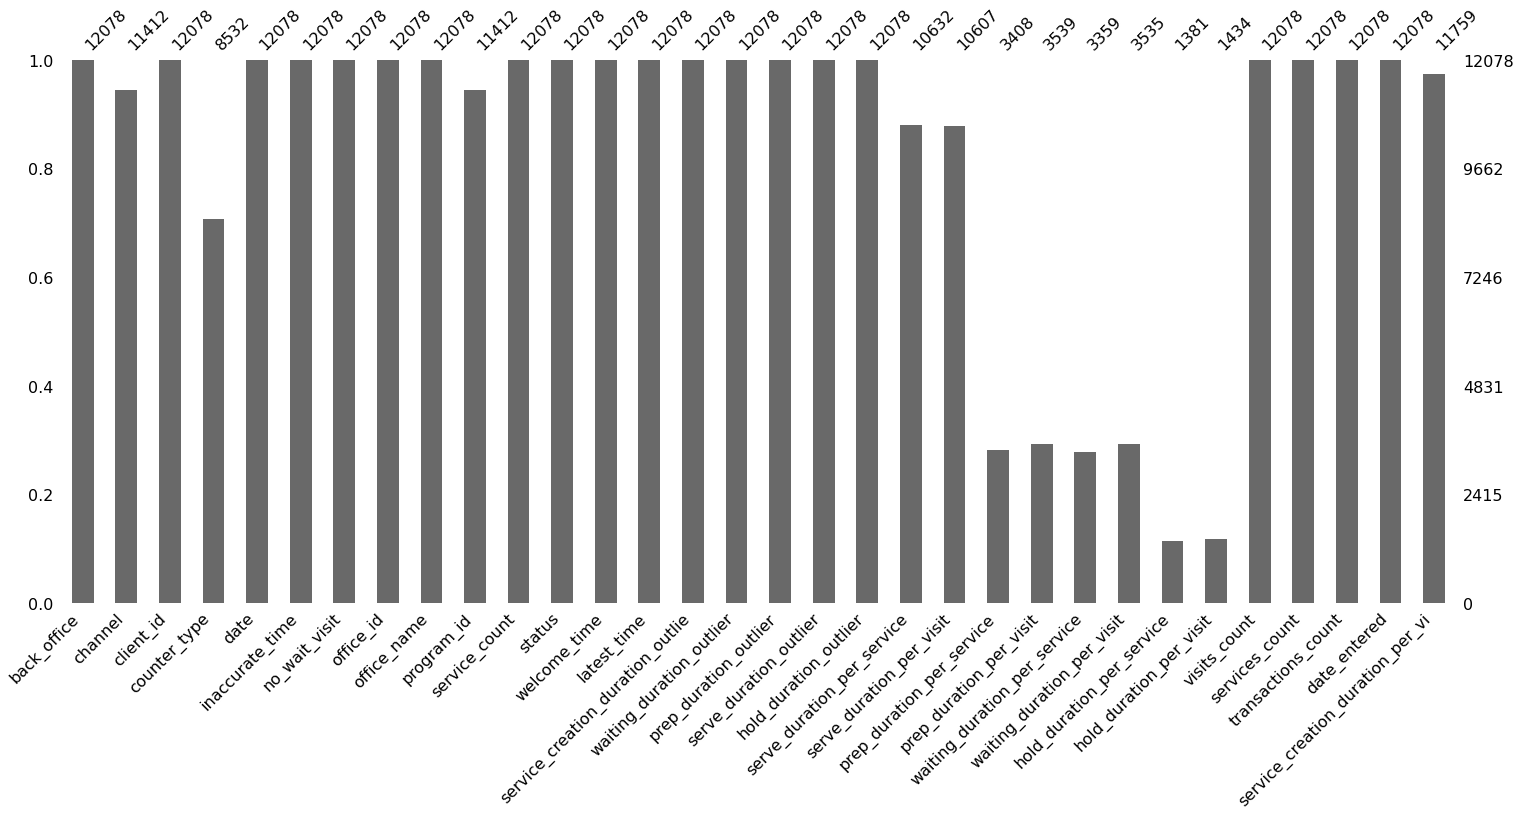

In [29]:
msno.bar(clean_visit_df)
plt.savefig('./output/Q visits non-null values by column.png');

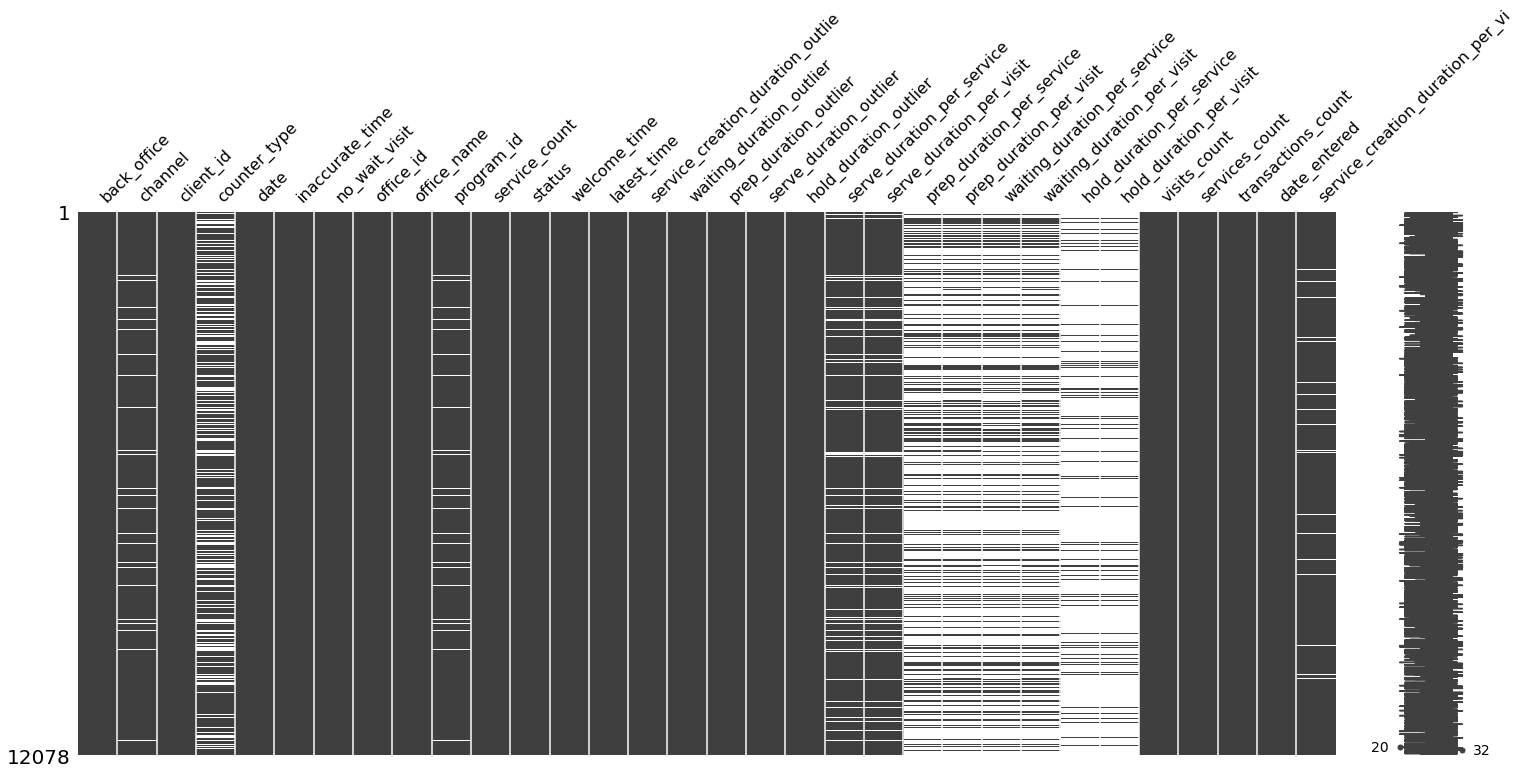

In [30]:
msno.matrix(clean_visit_df)
plt.savefig('./output/Q visits null values by row and column.png');

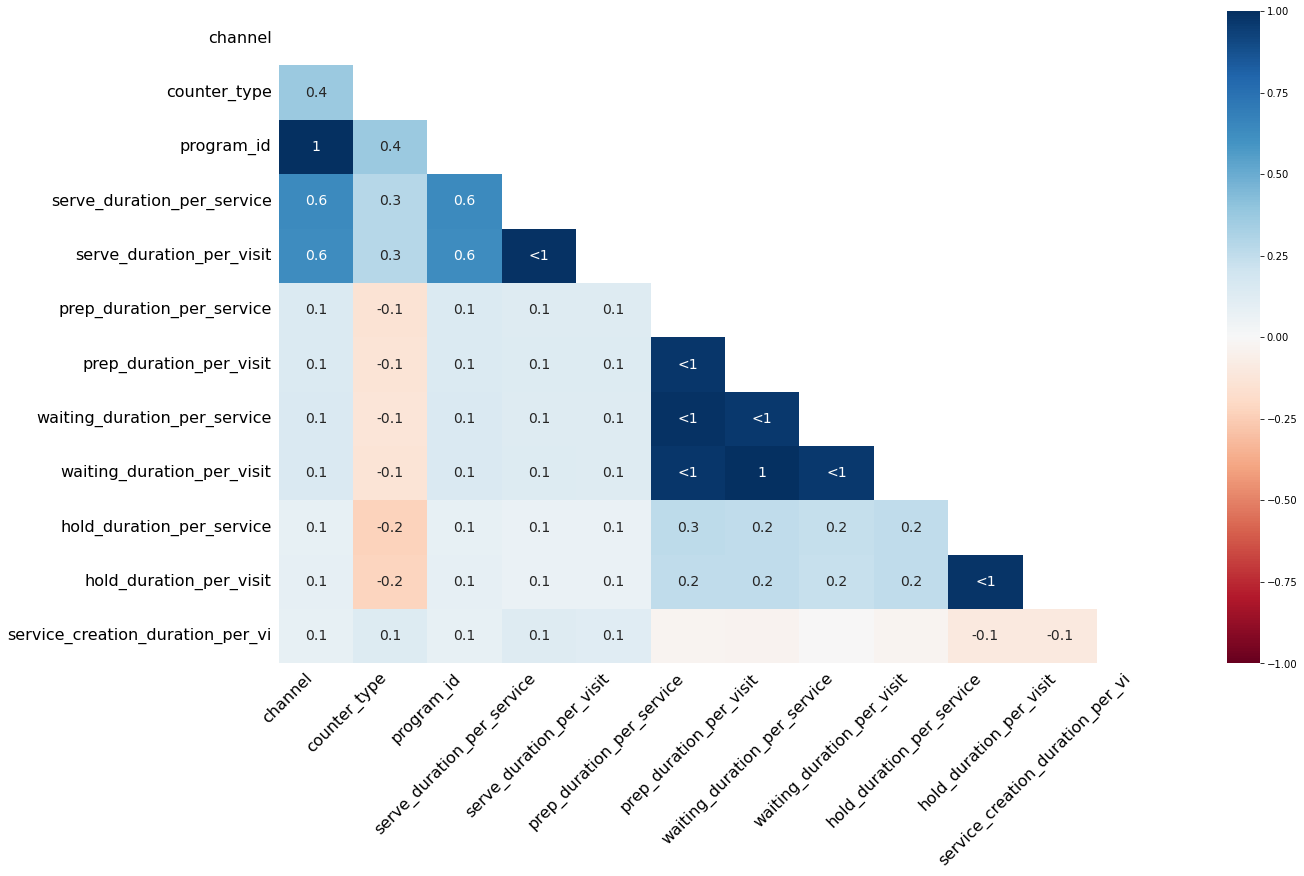

In [31]:
msno.heatmap(clean_visit_df)
plt.savefig('./output/Q visits null value correlation heatmap by position.png');

* Above statistics and the correlation heatmap show that channel and program_id are missing at the same time in all the rows. We can also see that hold duration is very sparsely populated which tells us that in the total time take for a service, hold time is generally negligible. Also, for the purposes of further analysis, we can safely impute zeroes for all the duration related fields.

* Also, there are fields denoting if the durations are outliers based on business logic. We can remove those rows from analysis for accurate analysis.

In [32]:
outlier_cols = [label for label in clean_visit_df.columns.tolist() if 'outlie' in label]
print('Rows before dropping outliers: {}'.format(clean_visit_df.shape[0]))
clean_visit_df = clean_visit_df[~clean_visit_df[outlier_cols].eq('Yes').any(axis=1)]
print('Rows after dropping outliers: {}'.format(clean_visit_df.shape[0]))

Rows before dropping outliers: 12078
Rows after dropping outliers: 11857


* Now that we have used the information in outlier fields, we can drop those columns as they will aid any further analysis.

In [33]:
clean_visit_df = clean_visit_df.drop(columns=outlier_cols)

* Lets impute the missing data in duration columns

In [34]:
duration_cols = [label for label in clean_visit_df.columns.tolist() if 'duration' in label]
print('% Null values in duration fields before imputation: {}'.format(clean_visit_df[duration_cols].isnull().mean()))
clean_visit_df.loc[:,duration_cols] = clean_visit_df.loc[:,duration_cols].fillna(0)
print('% Null values in duration fields after imputation: {}'.format(clean_visit_df[duration_cols].isnull().mean()))

% Null values in duration fields before imputation: serve_duration_per_service          0.118074
serve_duration_per_visit            0.120098
prep_duration_per_service           0.721346
prep_duration_per_visit             0.710298
waiting_duration_per_service        0.725394
waiting_duration_per_visit          0.710635
hold_duration_per_service           0.890191
hold_duration_per_visit             0.885722
service_creation_duration_per_vi    0.026398
dtype: float64
% Null values in duration fields after imputation: serve_duration_per_service          0.0
serve_duration_per_visit            0.0
prep_duration_per_service           0.0
prep_duration_per_visit             0.0
waiting_duration_per_service        0.0
waiting_duration_per_visit          0.0
hold_duration_per_service           0.0
hold_duration_per_visit             0.0
service_creation_duration_per_vi    0.0
dtype: float64


* Let's check the date range for any bad data

In [35]:
print(min(clean_visit_df['date']))
max(clean_visit_df['date'])


2018-07-12 00:00:00


Timestamp('2022-06-22 00:00:00')

* Now that bad data and null values have been dealt with appropriately, Q visits dataset seems to be clean and ready for further analysis.

### EDA 
* In this section we will analyse the clean datasets, join them with each other and other publicly avaialble datasets to analyse the performance of the offices, draw insights, and, suggest recommendations for improvements.

* How many offices and how many of each type does Services BC have ?

In [36]:
print('Total offices in the dataset are:{}'.format(clean_office['office_name'].nunique()))
print('Their distribution by size is as follows')
print('________________________________________')
clean_office['office_size'].value_counts()

Total offices in the dataset are:65
Their distribution by size is as follows
________________________________________


MICRO     21
SMALL     17
LARGE     15
MEDIUM    12
Name: office_size, dtype: int64

* The barplot below shows distribution of office sizes by category

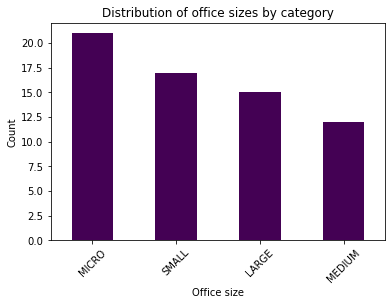

In [37]:
clean_office['office_size'].value_counts().plot(kind='bar', xlabel='Office size', ylabel='Count',
                                                 title='Distribution of office sizes by category',
                                                 colormap='viridis',
                                                 rot=45)
plt.savefig('./output/office distribution by size.png');

* How many offices are there per area name and what kind ?

In [38]:
clean_office['area_name'].value_counts()

North Coast               13
Kootenay                  13
Interior                  11
Lower Mainland Capital    11
Central Peace              9
Vancouver Island           8
Name: area_name, dtype: int64

* The barplot below shows distribution of office sizes by category

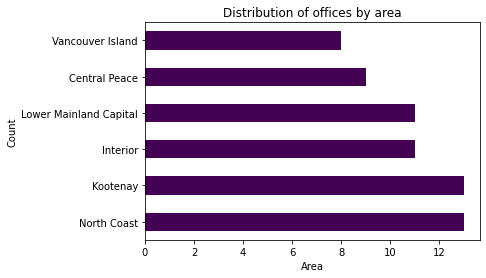

In [39]:
clean_office['area_name'].value_counts().plot(kind='barh', xlabel='Area', ylabel='Count',
                                                 title='Distribution of offices by area',
                                                 colormap='viridis')
plt.savefig('./output/office distribution by area.png');

* How are office of different sizes distributed across areas

In [40]:
clean_office.groupby('area_name')['office_size'].value_counts()

area_name               office_size
Central Peace           LARGE          3
                        MEDIUM         2
                        MICRO          2
                        SMALL          2
Interior                MICRO          5
                        LARGE          3
                        MEDIUM         2
                        SMALL          1
Kootenay                SMALL          7
                        MICRO          3
                        LARGE          2
                        MEDIUM         1
Lower Mainland Capital  LARGE          3
                        MEDIUM         3
                        MICRO          3
                        SMALL          2
North Coast             MICRO          7
                        MEDIUM         3
                        SMALL          3
Vancouver Island        LARGE          4
                        SMALL          2
                        MEDIUM         1
                        MICRO          1
Name: office_size, dt

**Observation:** Although north coast has the highest number of offices, more than half of them are micro sized.

**Merging the Office info and Q visits datasets**

* Q visits dataset can be joined with office info dataset using the foreign key (office_id) in the former with the primary key office_id in the latter.But upon analysing the two datasets, it looks like office_id is an auto_increment column in the office info dataset and not a key that can be used to join the tables.

* So, that leaves us with joining on office_name instead. Office name in Q visits can be used as a key to join office info dataset on either city or office_name.

* But, as we noticed above for one the offices in Queen Charlotte city, office name was different than city in office info dataset. So, let's create a new column that will same values as office name for all rows except for the one in Queen Charlotte city. We can then use this new column to merge both the datasets.

In [41]:
clean_office[clean_office['city']=='Queen Charlotte City'] # checking the office name of Queen Charlotte City in Office info dataset

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489


* Creating a merge key

In [42]:
clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'merge_key'] = clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'city']
clean_office.loc[clean_office['office_name'] != 'Daajing Giids', 'merge_key'] = clean_office.loc[clean_office['office_name'] != 'Daajing Giids', 'office_name']

<ipython-input-42-f5e959c2baf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'merge_key'] = clean_office.loc[clean_office['office_name'] == 'Daajing Giids', 'city']


In [43]:
clean_office.loc[clean_office['office_name'] == 'Daajing Giids'] #sanity check

,office_id,office_name,city,office_size,area,area_name,address,latitude,longitude,merge_key
45,46,Daajing Giids,Queen Charlotte City,SMALL,1.0,North Coast,216 Oceanview Dr,53.254551,-132.082489,Queen Charlotte City


In [44]:
# merging the datasets on merge key
cols_needed = ['office_size', 'area_name','latitude','longitude','merge_key']
merged_visit_df = clean_visit_df.merge(clean_office[cols_needed],left_on='office_name',right_on='merge_key').drop(columns='merge_key')
merged_visit_df.head()

,back_office,channel,client_id,counter_type,date,inaccurate_time,no_wait_visit,office_id,office_name,program_id,...,hold_duration_per_visit,visits_count,services_count,transactions_count,date_entered,service_creation_duration_per_vi,office_size,area_name,latitude,longitude
0,Back Office,back-office,4736921,Counter,2020-09-28,No,Yes,94,Victoria,Back Office - 002,...,0.0,1,1,1,2021-03-05 14:30:37.450,0.000073,LARGE,Lower Mainland Capital,48.458359,-123.377106
1,Back Office,back-office,5117850,Counter,2020-11-30,No,Yes,111,Victoria,ID Verification - 010,...,0.0,1,1,1,2021-03-05 14:30:50.080,0.000148,LARGE,Lower Mainland Capital,48.458359,-123.377106
2,Front Office,in-person,1131655,NaN,2019-01-31,Yes,No,94,Victoria,SDPR - POC - 009,...,0.0,1,1,1,2021-03-05 14:29:32.667,0.000349,LARGE,Lower Mainland Capital,48.458359,-123.377106
3,Back Office,back-office,4105534,Counter,2020-06-09,No,Yes,94,Victoria,Back Office - 020,...,0.0,1,1,1,2021-03-05 14:30:19.887,0.000006,LARGE,Lower Mainland Capital,48.458359,-123.377106
4,Front Office,in-person,4380879,Counter,2020-07-28,Yes,No,94,Victoria,MSP - 001,...,0.0,1,1,1,2021-03-05 14:30:27.353,0.000005,LARGE,Lower Mainland Capital,48.458359,-123.377106


In [45]:
merged_visit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11857 entries, 0 to 11856
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   back_office                       11857 non-null  object        
 1   channel                           11206 non-null  object        
 2   client_id                         11857 non-null  int64         
 3   counter_type                      8405 non-null   object        
 4   date                              11857 non-null  datetime64[ns]
 5   inaccurate_time                   11857 non-null  object        
 6   no_wait_visit                     11857 non-null  object        
 7   office_id                         11857 non-null  int64         
 8   office_name                       11857 non-null  object        
 9   program_id                        11206 non-null  object        
 10  service_count                     11857 non-nu

* Let's examine the distribution of transactions across the Service BC centres.

In [46]:
transactions_by_office = merged_visit_df.groupby(['office_name','office_size']).agg(transaction_count=('client_id','count')).reset_index()
transactions_by_office.sort_values(by='transaction_count')

,office_name,office_size,transaction_count
33,Masset,MICRO,11
9,Clinton,MICRO,14
3,Bella Coola,MICRO,20
27,Kaslo,MICRO,34
59,Valemount,MICRO,35
...,...,...,...
40,Port Alberni,MEDIUM,442
10,Courtenay,LARGE,464
32,Maple Ridge,LARGE,506
43,Prince George,LARGE,552


* Let's examine the same by office size

In [47]:
merged_visit_df.groupby('office_size')['client_id'].count().sort_values()

office_size
MICRO     1489
SMALL     1568
MEDIUM    2968
LARGE     5832
Name: client_id, dtype: int64

* 4/5 offices with highest transactions are large offices which shows that office size and transaction volume are highly correlated.

* Let's examine the different program id's handled and their transaction volume across the Service BC centres.

In [48]:
service_counts_by_office =  merged_visit_df.groupby(['office_name','program_id']).agg(program_id_count=('client_id','count')).reset_index()
service_counts_by_office.head()                                                                       

,office_name,program_id,program_id_count
0,100 Mile House,BC Registry - 004,1
1,100 Mile House,BC Registry - 005,1
2,100 Mile House,Back Office - 001,4
3,100 Mile House,Back Office - 002,2
4,100 Mile House,Back Office - 004,6


* We know that Vernon handled the highest transactions, let's see what are the top 5 program id's handled by the office.

In [49]:
service_counts_by_office[service_counts_by_office['office_name']=='Vernon'].sort_values(by='program_id_count',ascending=False).head()

,office_name,program_id,program_id_count
2448,Vernon,ICBC - 002,138
2435,Vernon,Back Office - 021,58
2454,Vernon,ICBC - 009,38
2462,Vernon,ID Verification - 010,34
2433,Vernon,Back Office - 017,27


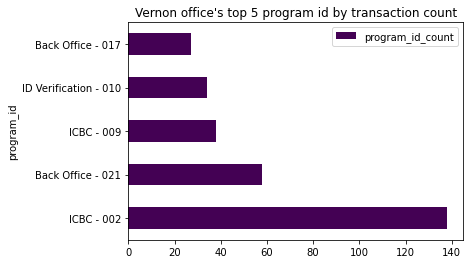

In [50]:
service_counts_by_office[service_counts_by_office['office_name']=='Vernon'].sort_values(by='program_id_count',ascending=False).head().plot(y='program_id_count',x='program_id',kind='barh', colormap='viridis')
plt.title("Vernon office's top 5 program id by transaction count");

* Let's examine the distribution of transactions across different areas.

In [51]:
transactions_by_area = merged_visit_df.groupby('area_name')['client_id'].count().sort_values()
transactions_by_area

area_name
North Coast               1471
Kootenay                  1725
Vancouver Island          2113
Central Peace             2151
Interior                  2190
Lower Mainland Capital    2207
Name: client_id, dtype: int64

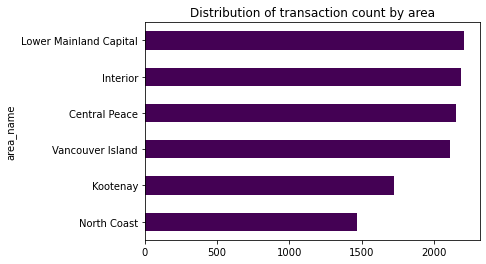

In [52]:
transactions_by_area.plot(kind='barh',colormap='viridis')
plt.title('Distribution of transaction count by area')
plt.savefig('./output/distribution of transaction count by area.png');

* Let's examine the channels of transactions

In [53]:
transactions_by_channel = merged_visit_df.groupby(['back_office','channel']).agg(transaction_count=('client_id','count')).reset_index().sort_values(by='transaction_count',ascending=0)
transactions_by_channel.head()

,back_office,channel,transaction_count
6,Front Office,in-person,7007
0,Back Office,back-office,3684
8,Front Office,phone,228
1,Back Office,in-person,153
2,Back Office,phone,78


In [54]:
transactions_by_channel['percentage_of_total'] = 100*transactions_by_channel['transaction_count']/transactions_by_channel['transaction_count'].sum()
transactions_by_channel

,back_office,channel,transaction_count,percentage_of_total
6,Front Office,in-person,7007,62.529002
0,Back Office,back-office,3684,32.875245
8,Front Office,phone,228,2.034624
1,Back Office,in-person,153,1.365340
2,Back Office,phone,78,0.696056
3,Front Office,back-office,30,0.267714
5,Front Office,email-fax-mail,14,0.124933
4,Front Office,cats-assist,7,0.062467
7,Front Office,mobile-assist,5,0.044619


* Over 60% of the transactions are handled in-person by the front office

* Let's analyse this mode over time to see if there is a trend. Covid time might have a say here.

In [55]:
merge_copy = merged_visit_df.copy()
merge_copy['month'] = merge_copy['date'].dt.month
merge_copy['year'] = merge_copy['date'].dt.year
monthly_data = merge_copy.groupby(['year','month','back_office','channel']).agg(transaction_count=('client_id','count')).reset_index().sort_values(by=['year','month'])
monthly_data.head()

,year,month,back_office,channel,transaction_count
0,2018,7,Back Office,back-office,1
1,2018,7,Back Office,in-person,1
2,2018,7,Front Office,back-office,1
3,2018,7,Front Office,in-person,12
4,2018,8,Back Office,back-office,2


In [56]:
in_person = monthly_data[(monthly_data['back_office']=='Front Office') & (monthly_data['channel']=='in-person')]
in_person.head()

,year,month,back_office,channel,transaction_count
3,2018,7,Front Office,in-person,12
7,2018,8,Front Office,in-person,20
11,2018,9,Front Office,in-person,42
15,2018,10,Front Office,in-person,103
20,2018,11,Front Office,in-person,99


In [57]:
in_person['year_month'] = pd.to_datetime(in_person['year'].astype('str')+'-'+in_person['month'].astype('str'),format='%Y-%m')

<ipython-input-57-cc8d059175b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_person['year_month'] = pd.to_datetime(in_person['year'].astype('str')+'-'+in_person['month'].astype('str'),format='%Y-%m')


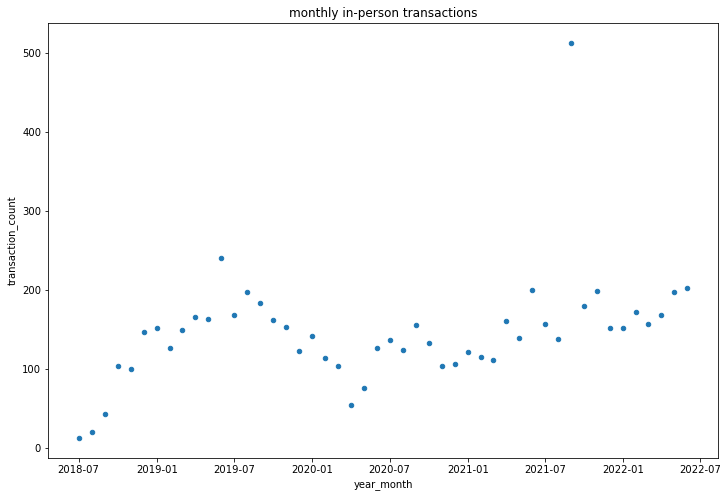

In [58]:
in_person.sort_values(by=['year','month']).plot(x='year_month',y='transaction_count',kind='scatter',figsize=(12,8))
plt.title('monthly in-person transactions');

**Observations**: 
* We can clearly see a drop in monthly in person transaction during covid-19 duration (lockdowns and restrictions). Transaction count suddenly jumps to over 500 in september 2021 which is probably when new restrictions have been announced. Also, the latest data indicates an uptick towards pre-covid levels.

* Let's add covid-data to the dataset to see if the in-person transactions are correlated to the covid case load. Covid19 case load data has been downloaded from BCCDC.

In [59]:
covid_df = pd.read_csv('./data/covid19.csv',parse_dates=True)
covid_df.head()

,Reported_Date,HA,Sex,Age_Group,Classification_Reported
0,06-02-2020,Vancouver Coastal,F,50-59,Lab-diagnosed
1,18-02-2020,Interior,F,30-39,Lab-diagnosed
2,24-02-2020,Fraser,F,30-39,Lab-diagnosed
3,24-02-2020,Fraser,M,40-49,Lab-diagnosed
4,03-03-2020,Fraser,M,50-59,Lab-diagnosed


In [60]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374886 entries, 0 to 374885
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Reported_Date            374886 non-null  object
 1   HA                       374886 non-null  object
 2   Sex                      374886 non-null  object
 3   Age_Group                374886 non-null  object
 4   Classification_Reported  374886 non-null  object
dtypes: object(5)
memory usage: 14.3+ MB


<ipython-input-61-9096e0f6d3fa>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  covid_df['date'] = pd.to_datetime(covid_df['Reported_Date'])


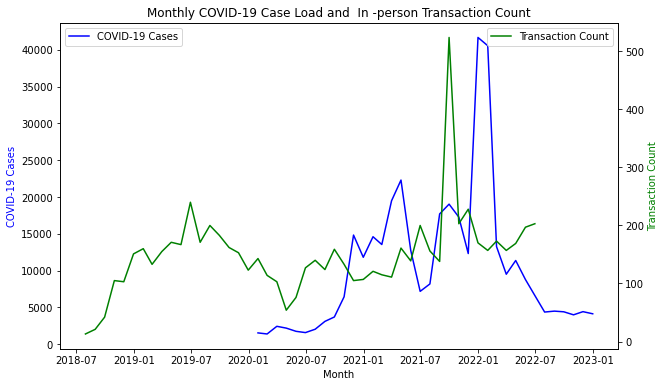

In [61]:
# Preprocess COVID-19 data
covid_df['date'] = pd.to_datetime(covid_df['Reported_Date'])
monthly_case_counts = covid_df.groupby(pd.Grouper(key='date', freq='M')).size()

# Preprocess transaction dat
monthly_transaction_counts = merged_visit_df[merged_visit_df['channel']=='in-person'].groupby(pd.Grouper(key='date', freq='M')).size()

# Create a single plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot monthly case counts on the first y-axis
ax1.plot(monthly_case_counts.index, monthly_case_counts.values, label='COVID-19 Cases', color='blue')
ax1.set_ylabel('COVID-19 Cases', color='blue')

# Plot monthly transaction counts on the second y-axis
ax2.plot(monthly_transaction_counts.index, monthly_transaction_counts.values, label='Transaction Count', color='green')
ax2.set_ylabel('Transaction Count', color='green')

# Customize the plot
ax1.set_title('Monthly COVID-19 Case Load and  In -person Transaction Count')
ax1.set_xlabel('Month')

# Display legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

* Covid indeed showed a decline in in-person transaction count. It can be clearly seen that whenever the case load increase, there is decrease in transaction count and vice-versa. Also, we can see a rise in the transaction count as covid numbers dwindled in 2022.

* Let's analyse the program id's to see which program id's are popular

In [62]:
merged_visit_df['program_id'].value_counts()

ICBC - 002                1450
ID Verification - 010     1207
Back Office - 021         1119
ICBC - 008                 481
ICBC - 009                 336
                          ... 
Other - 006                  1
LCRB - 005                   1
MCFD - 001                   1
SDPR - 3rd Party - 008       1
SDPR - POC - 002             1
Name: program_id, Length: 182, dtype: int64

In [63]:
merged_visit_df['program_id'].value_counts()/merged_visit_df['program_id'].count()

ICBC - 002                0.129395
ID Verification - 010     0.107710
Back Office - 021         0.099857
ICBC - 008                0.042923
ICBC - 009                0.029984
                            ...   
Other - 006               0.000089
LCRB - 005                0.000089
MCFD - 001                0.000089
SDPR - 3rd Party - 008    0.000089
SDPR - POC - 002          0.000089
Name: program_id, Length: 182, dtype: float64

**Observation: 3 of the ICBC program id's account for 20% of the transactions.**

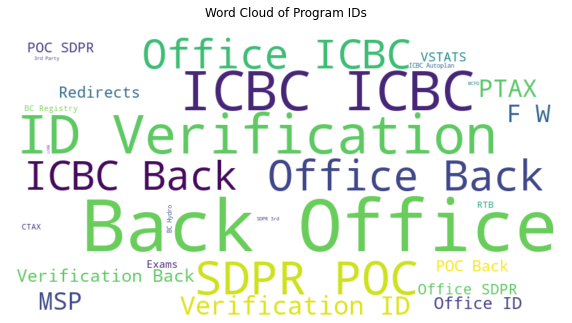

In [64]:
# Concatenate all program IDs into a single string
text = ' '.join(merged_visit_df['program_id'].dropna().astype(str))

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Program IDs', pad=20)
# plt.savefig('./output/word cloud of programs.png')
plt.show()

* Now, let's examine the popular program id's in each area

In [65]:
merged_visit_df.groupby(['area_name','program_id'])['client_id'].count().sort_values(ascending=False)

area_name               program_id           
Vancouver Island        ICBC - 002               379
Lower Mainland Capital  ID Verification - 010    379
Central Peace           ICBC - 002               321
Interior                ICBC - 002               274
Kootenay                Back Office - 021        246
                                                ... 
North Coast             Other - 047                1
Kootenay                BC Registry - 002          1
North Coast             RTB - 001                  1
                        RTB - 002                  1
                        Redirects - 004            1
Name: client_id, Length: 733, dtype: int64

* Let's narrow down the output to top 5 program id's by transaction count in each area

In [66]:
# Group the DataFrame by 'area' and 'program_id', and count the occurrences
program_counts = merged_visit_df.groupby(['area_name', 'program_id']).size().reset_index(name='count')

# Sort the program_counts DataFrame within each 'area' by the count in descending order
program_counts_sorted = program_counts.groupby('area_name').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Display the top 5 programs handled by each area
print(program_counts_sorted)

                 area_name             program_id  count
0            Central Peace             ICBC - 002    321
1            Central Peace      Back Office - 021    167
2            Central Peace  ID Verification - 010    162
3            Central Peace             ICBC - 008    124
4            Central Peace             PTAX - 005     88
5                 Interior             ICBC - 002    274
6                 Interior      Back Office - 021    207
7                 Interior  ID Verification - 010    185
8                 Interior             ICBC - 009     73
9                 Interior             ICBC - 008     66
10                Kootenay      Back Office - 021    246
11                Kootenay  ID Verification - 010    154
12                Kootenay             ICBC - 002    149
13                Kootenay             PTAX - 005     76
14                Kootenay      Back Office - 004     72
15  Lower Mainland Capital  ID Verification - 010    379
16  Lower Mainland Capital     

* ICBC -002 is the most popular service in 4/6 areas and is in top 3 in all of them

* Let's examine the transaction counts by service_status and service_count

In [67]:
merged_visit_df['service_count'].value_counts()

1     11369
2       381
3        69
4        19
5         6
6         4
7         4
8         2
19        1
13        1
17        1
Name: service_count, dtype: int64

* Looks like more than 95% of transactions have a service count of 1.

In [68]:
merged_visit_df['status'].value_counts()


Finished                            10387
Inaccurate Time                       644
Customer Left (service-creation)      594
Being Served                           51
missing_calls                          44
Customer Left (at-prep)                39
Customer Left (being-served)           30
At Service Creation                    30
On Hold                                18
Waiting in Line                         9
At Prep                                 6
Open Ticket                             3
Override                                1
Customer Left                           1
Name: status, dtype: int64

* A vast majority of the transactions are usually finished. It isn't clear if inaccurate time status is a finished transaction or not.

* Let's now examine durations by various factors just like we analysed transaction counts. But we before that we need to understand the relationship between datetime fields and durations

In [69]:
merged_visit_df['total_service_time'] = (merged_visit_df['latest_time']-merged_visit_df['welcome_time']).astype('timedelta64[s]')
merged_visit_df['total_service_time'].head()

0     968.0
1     112.0
2    1010.0
3     538.0
4      12.0
Name: total_service_time, dtype: float64

* The duration data seems to be in the units of days. Let's connvert that to seconds for better readability.

In [70]:
merged_visit_df[duration_cols] = merged_visit_df[duration_cols]*24*3600
merged_visit_df[duration_cols].head()

,serve_duration_per_service,serve_duration_per_visit,prep_duration_per_service,prep_duration_per_visit,waiting_duration_per_service,waiting_duration_per_visit,hold_duration_per_service,hold_duration_per_visit,service_creation_duration_per_vi
0,961.666966,961.666966,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.272001
1,99.234996,99.234996,0.000000,0.000000,0.000000,0.000000,0.0,0.0,12.749003
2,0.000000,0.000000,786.234963,786.234963,191.760998,191.760998,0.0,0.0,30.150999
3,537.508008,537.508008,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.530000
4,0.000000,0.000000,3.393999,3.393999,5.390997,5.390997,0.0,0.0,0.446000


* Let's add all the components of a service to compute cumulative service time per service as well per visit

In [71]:
merged_visit_df['cumulative_service_time_per_service'] = round(merged_visit_df['serve_duration_per_service']+merged_visit_df['prep_duration_per_service']+merged_visit_df['waiting_duration_per_service']+merged_visit_df['hold_duration_per_service']+merged_visit_df['service_creation_duration_per_vi'])

In [72]:
merged_visit_df['cumulative_service_time_per_visit'] = round(merged_visit_df['serve_duration_per_visit']+merged_visit_df['prep_duration_per_visit']+merged_visit_df['waiting_duration_per_visit']+merged_visit_df['hold_duration_per_visit']+merged_visit_df['service_creation_duration_per_vi'])

* Let's examine the inaccurate_time field, no_wait_time field, and, service_count field for the split in transactions

In [73]:
inaccurate_time = merged_visit_df[merged_visit_df['inaccurate_time']=='Yes']

In [74]:
merged_visit_df['inaccurate_time'].value_counts()

No     11210
Yes      647
Name: inaccurate_time, dtype: int64

In [75]:
merged_visit_df['no_wait_visit'].value_counts()

Yes    8099
No     3758
Name: no_wait_visit, dtype: int64

In [76]:
merged_visit_df['service_count'].value_counts()

1     11369
2       381
3        69
4        19
5         6
6         4
7         4
8         2
19        1
13        1
17        1
Name: service_count, dtype: int64

* Checking if no_wait_visit correlates to zero waiting time 

In [77]:
merged_visit_df[(merged_visit_df['no_wait_visit']=='Yes')&((merged_visit_df['waiting_duration_per_service']!=0) | (merged_visit_df['waiting_duration_per_visit']!=0))].shape[0]

234

* Apart from 234 rows, it seems that no_wait_visit flag is accuarately representing the customer wait

* Let's get summary statistics on the duration columns

In [78]:
time_cols = duration_cols + ['total_service_time','cumulative_service_time_per_service','cumulative_service_time_per_visit']
merged_visit_df[time_cols].describe()

,serve_duration_per_service,serve_duration_per_visit,prep_duration_per_service,prep_duration_per_visit,waiting_duration_per_service,waiting_duration_per_visit,hold_duration_per_service,hold_duration_per_visit,service_creation_duration_per_vi,total_service_time,cumulative_service_time_per_service,cumulative_service_time_per_visit
count,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000,11857.000000
mean,398.329285,440.698463,3.622552,4.059011,135.390263,144.997449,250.883981,278.705486,18.776246,1009.500042,806.998651,887.233786
std,622.515934,740.960665,28.645501,31.587808,401.557794,422.292439,2024.739063,2135.046918,50.313731,6017.206133,2254.604563,2431.442574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.049995,50.368997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.952996,96.000000,81.000000,90.000000
50%,215.719010,234.857007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.559998,336.000000,296.000000,330.000000
75%,490.274994,530.504986,0.002000,0.966004,0.002000,3.284997,0.000000,0.000000,15.828998,867.000000,788.000000,857.000000
max,11324.040123,14677.020694,2213.951054,2213.951054,5431.081225,8347.586993,81827.770044,81827.770044,1805.884070,414991.000000,81838.000000,81838.000000


* It looks like we have some extreme values in the duration fields either direactions.

* Let's take look at the rows that have service duration as zeroes.

In [79]:
merged_visit_df[merged_visit_df['serve_duration_per_visit'] ==0].shape[0]

1424

In [80]:
merged_visit_df[merged_visit_df['serve_duration_per_visit'] ==0]['status'].value_counts()

Inaccurate Time                     644
Customer Left (service-creation)    594
Being Served                         51
Customer Left (at-prep)              37
missing_calls                        33
Finished                             27
At Service Creation                  25
Waiting in Line                       6
At Prep                               3
On Hold                               2
Override                              1
Customer Left                         1
Name: status, dtype: int64

* Looks like all zero duration service times correspond to unfinished status of the transaction. Hence we can drop these rows for duration related analysis.

In [81]:
print('Rows before dropping zero service duation: {}'.format(merged_visit_df.shape[0]))
merged_visit_df = merged_visit_df[merged_visit_df['serve_duration_per_visit']!=0]
print('Rows after dropping zero service duation: {}'.format(merged_visit_df.shape[0]))

Rows before dropping zero service duation: 11857
Rows after dropping zero service duation: 10433


In [82]:
merged_visit_df[time_cols].quantile([.05,.25,.50,0.8,0.9,0.95,0.99])

,serve_duration_per_service,serve_duration_per_visit,prep_duration_per_service,prep_duration_per_visit,waiting_duration_per_service,waiting_duration_per_visit,hold_duration_per_service,hold_duration_per_visit,service_creation_duration_per_vi,total_service_time,cumulative_service_time_per_service,cumulative_service_time_per_visit
0.05,13.413400,19.745797,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.191000,26.00,26.00,29.00
0.25,96.896002,108.769997,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.052002,130.00,125.00,137.00
0.50,267.560004,296.138004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,6.586004,373.00,357.00,391.00
0.80,633.113797,690.931374,1.578001,1.728797,64.405800,87.828598,0.00000,0.000000,19.672798,1089.00,1050.00,1150.00
0.90,1021.915825,1123.921825,6.317800,7.251198,473.597581,522.145011,0.00000,0.000000,35.955602,1869.80,1808.40,1956.20
0.95,1562.588408,1702.493635,18.538599,20.051201,967.562821,1027.304623,135.38500,257.708002,64.680402,2805.40,2712.20,2943.60
0.99,3110.661516,3383.173853,55.514640,63.969918,2076.654221,2133.020470,6406.53494,7142.226232,204.791926,9389.32,8167.52,9570.84


* To make a meaningful analysis and reporting, let us take the 95th percentile on cumulative_service_time_per_visit as the cut-off.

In [83]:
print('Rows before dropping based on cut-off on cumulative service duation: {}'.format(merged_visit_df.shape[0]))
merged_visit_df = merged_visit_df[merged_visit_df['cumulative_service_time_per_visit']<=merged_visit_df['cumulative_service_time_per_visit'].quantile(0.95)]
print('Rows after dropping based on cut-off on cumulative service duation: {}'.format(merged_visit_df.shape[0]))

Rows before dropping based on cut-off on cumulative service duation: 10433
Rows after dropping based on cut-off on cumulative service duation: 9911


<ipython-input-84-6b003c38f9d8>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged_visit_df[time_cols].hist(bins=30,ax=ax)


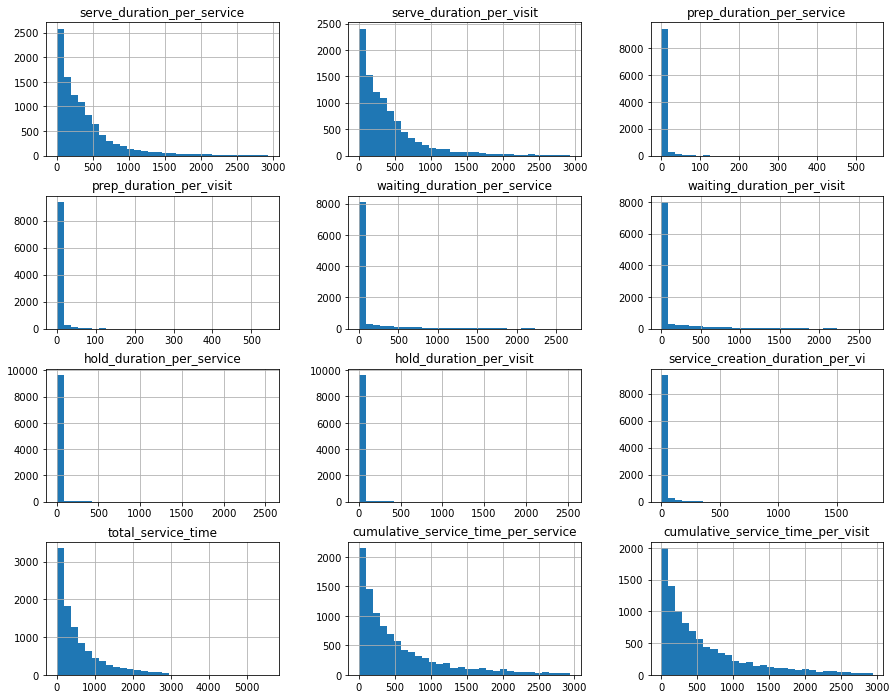

In [84]:
fig, ax = plt.subplots(figsize=(15,12))
merged_visit_df[time_cols].hist(bins=30,ax=ax)
plt.savefig('Distribution of different components of service duration.png');

### Analyzing Transaction Duration

we will examine how long transactions take at each office and if there is any correlation with office size.

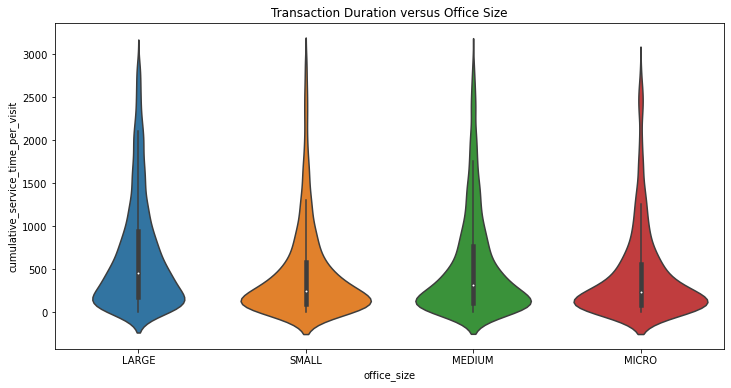

In [85]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='office_size', y='cumulative_service_time_per_visit', data=merged_visit_df)
plt.title('Transaction Duration versus Office Size')
plt.show()

* The presence of extreme values or outliers can distort the visualization and make it difficult to detect patterns. One way to handle this is to consider log transformation of data. This can help to minimize the effect of the skewness caused by these extreme values.

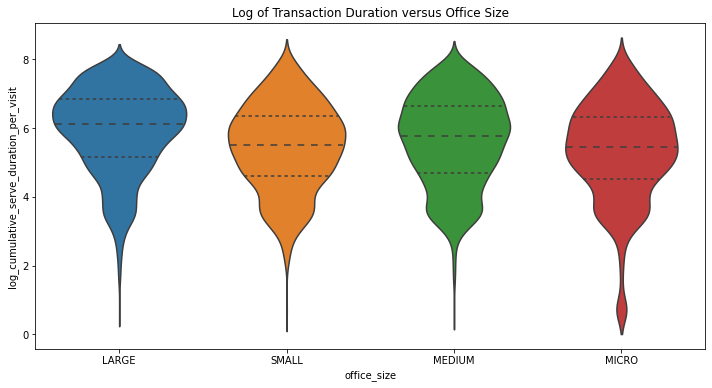

In [86]:
merged_visit_df['log_cumulative_serve_duration_per_visit'] = np.log(merged_visit_df['cumulative_service_time_per_visit'] + 1)  # Added 1 to handle zero values

plt.figure(figsize=(12, 6))
sns.violinplot(x='office_size', y='log_cumulative_serve_duration_per_visit', data=merged_visit_df,inner='quartile')
plt.title('Log of Transaction Duration versus Office Size')
plt.show()

## Insights and Recommendations

From our analysis, we have the following key findings:

- Finding 1: The office size has an impact on the volume of transactions. Larger offices tend to have more transactions.
- Finding 2: Larger offices tend to take longer to serve customers. On a log scale, they take about 1/2 unit longer, which translates to approximately 3 times longer on the original time scale.

Based on these findings, we can make the following recommendations:

- Recommendation 1: Allocate more resources (staff, equipment etc.) to larger offices to handle the higher volume of transactions.
- Recommendation 2: Implement efficiencies in larger offices to reduce service times, such as more efficient queuing systems, additional training for staff, or improved office layouts.

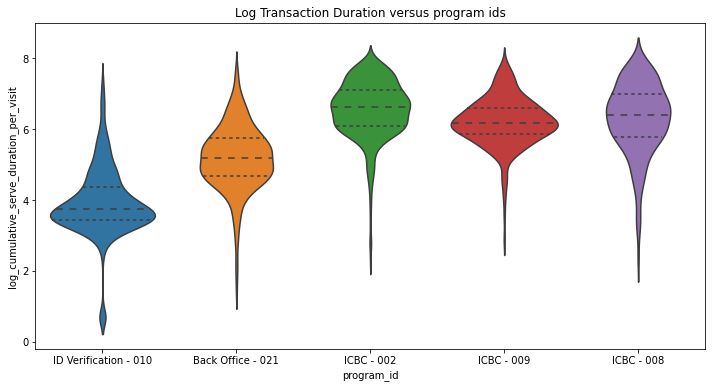

In [87]:
# duration by program id
program_ids = ['ICBC - 002','ID Verification - 010','Back Office - 021','ICBC - 008','ICBC - 009']
plt.figure(figsize=(12, 6))
sns.violinplot(x='program_id', y='log_cumulative_serve_duration_per_visit', data=merged_visit_df[merged_visit_df['program_id'].isin(program_ids)],inner='quartile')
plt.title('Log Transaction Duration versus program ids')
plt.show()

* In general, ICBC program id's take longer than other program ids. 
  It may be recommended to improve the process as ICBC program id's as they dominate the transaction count as well.

In [88]:
time_stats_by_office = merged_visit_df[time_cols +['client_id','office_name','area_name','office_size']].groupby(['office_name','area_name','office_size']).agg(transaction_count = ('client_id','count'),
                                                                                                                                    median_serve_duration_per_service = ('serve_duration_per_service','median'),
                                                                                                                        median_serve_duration_per_visit = ('serve_duration_per_visit','median'),
                                                                                                                        median_service_creation_duration_per_visit = ('service_creation_duration_per_vi','median'),
                                                                                                                        median_prep_duration_per_visit = ('prep_duration_per_visit','median'),
                                                                                                                        median_prep_duration_per_service = ('prep_duration_per_service','median'),
                                                                                                                        median_waiting_duration_per_visit = ('waiting_duration_per_visit','median'),
                                                                                                                        median_waiting_duration_per_service = ('waiting_duration_per_service','median'),
                                                                                                                        median_hold_duration_per_visit = ('hold_duration_per_visit','median'),
                                                                                                                        median_hold_duration_per_service = ('hold_duration_per_service','median'),
                                                                                                                        median_total_service_time = ('total_service_time','median'),
                                                                                                                        median_cumulative_service_time_per_service = ('cumulative_service_time_per_service','median'),
                                                                                                                        median_cumulative_service_time_per_visit = ('cumulative_service_time_per_visit','median')                                                                                                                        
                                                                                                              ).reset_index()

In [89]:
time_stats_by_office.sample(5).T

,21,12,8,52,20
office_name,Golden,Creston,Chilliwack,Sparwood,Ganges
area_name,Kootenay,Kootenay,Lower Mainland Capital,Kootenay,Lower Mainland Capital
office_size,MICRO,SMALL,LARGE,SMALL,MICRO
transaction_count,38,66,363,81,30
median_serve_duration_per_service,320.059007,238.285502,282.522004,209.359996,240.316502
median_serve_duration_per_visit,320.059007,241.456494,300.558997,218.543996,255.012507
median_service_creation_duration_per_visit,5.376499,7.275498,8.962998,6.600001,8.498498
median_prep_duration_per_visit,0.0,0.0,0.001,0.0,0.0
median_prep_duration_per_service,0.0,0.0,0.001,0.0,0.0
median_waiting_duration_per_visit,0.0,0.0,0.001,0.0,0.0


* Which are the top 5 performing offices and bottom 5 perfoming offices by median service time

In [90]:
time_stats_by_office.sort_values(by='median_cumulative_service_time_per_visit')[['office_name','area_name','office_size','transaction_count','median_cumulative_service_time_per_visit']].head(5).T

,55,58,18,59,42
office_name,Surrey,Ucluelet,Fort St. James,Valemount,Powell River
area_name,Lower Mainland Capital,Vancouver Island,North Coast,Interior,Vancouver Island
office_size,MEDIUM,MICRO,MICRO,MICRO,SMALL
transaction_count,155,48,169,31,60
median_cumulative_service_time_per_visit,68.0,77.5,94.0,98.0,119.0


In [91]:
time_stats_by_office.sort_values(by='median_cumulative_service_time_per_visit')[['office_name','area_name','transaction_count','median_cumulative_service_time_per_visit']].tail(5).T

,10,62,43,49,56
office_name,Courtenay,Vernon,Prince George,Salmon Arm,Terrace
area_name,Vancouver Island,Interior,Central Peace,Interior,North Coast
transaction_count,400,516,455,290,189
median_cumulative_service_time_per_visit,598.5,625.0,632.0,633.0,648.0


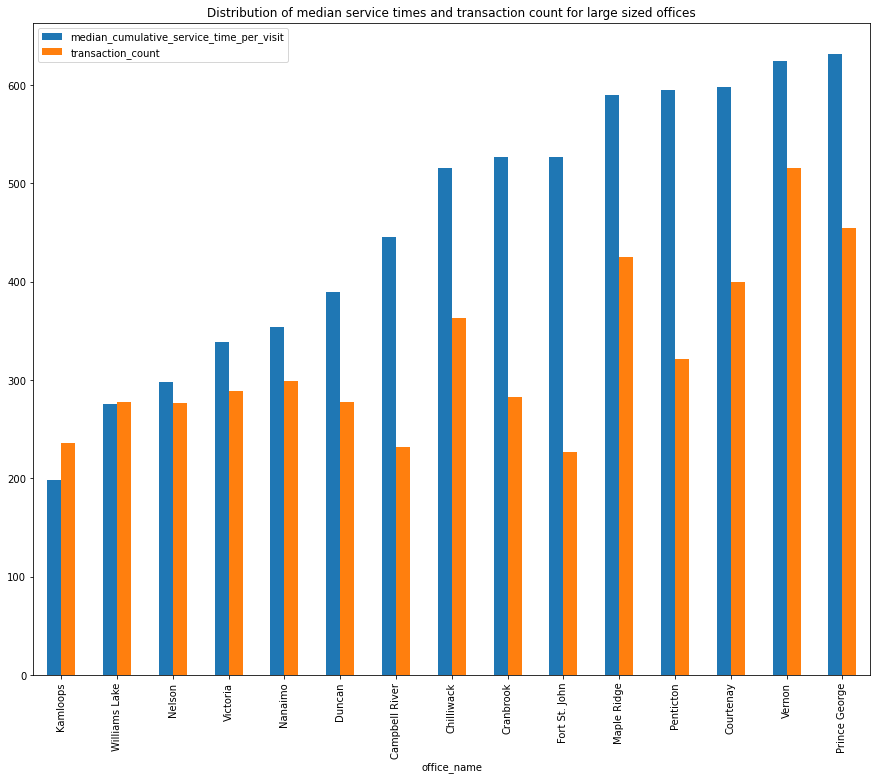

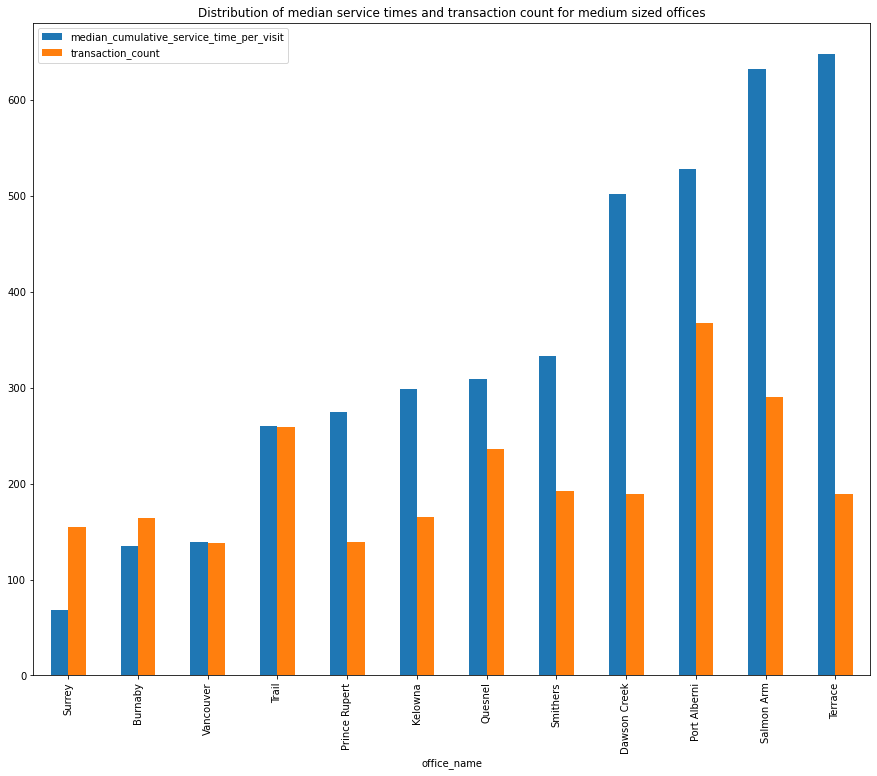

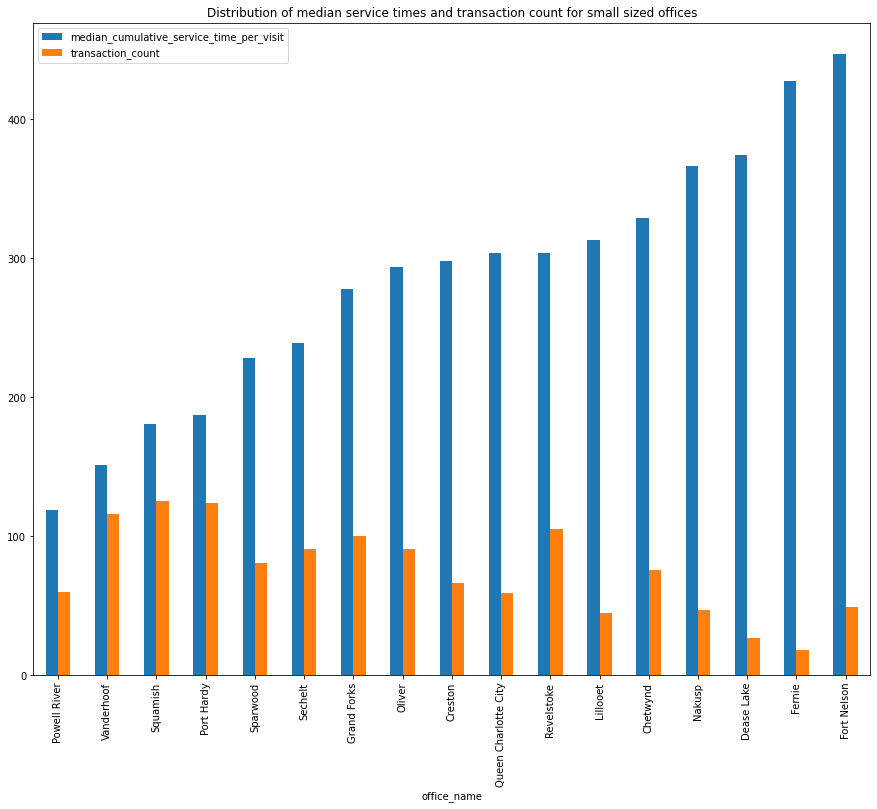

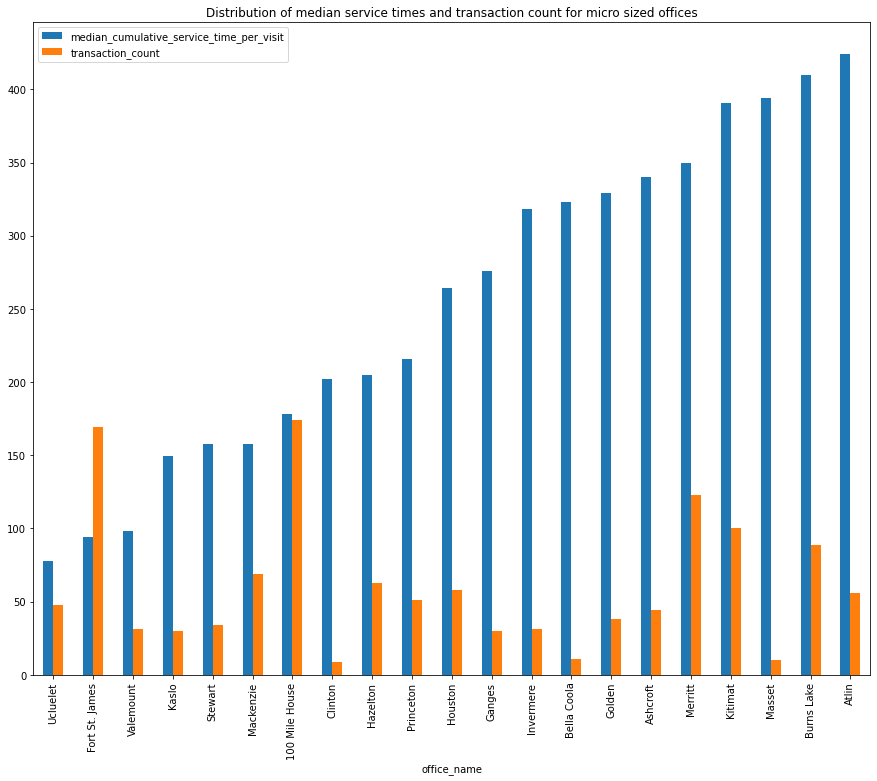

In [92]:
office_sizes = ['LARGE','MEDIUM','SMALL','MICRO']
for office_size in office_sizes:
    plot_df = time_stats_by_office[time_stats_by_office['office_size']==office_size].sort_values(by='median_cumulative_service_time_per_visit')
    title = 'Distribution of median service times and transaction count for {} sized offices'.format(office_size.lower())
    plot_df.plot(x='office_name', y=['median_cumulative_service_time_per_visit','transaction_count'],kind='bar',figsize=(15,12),title=title)
    plt.savefig('./output/distribution of median service times by office size for {} sized offices.png'.format(office_size.lower()))

* Let's bring in population data for each city for demographic analysis. The pop_municipal_subprov_areas has been used to add population data for each city in the dataset.
It is assumed that the population change is not significant over the date range and the 2021 estimates have been used.

In [93]:
population_df = pd.read_csv('./data/population.csv')
population_df.head()

,city,population
0,100 Mile House,2026
1,Ashcroft,1703
2,Atlin,424
3,Bella Coola,937
4,Burns Lake,1887


In [94]:
merged_visit_df = merged_visit_df.merge(population_df,left_on='office_name',right_on='city',how='left')
merged_visit_df.head().T

,0,1,2,3,4
back_office,Back Office,Back Office,Back Office,Back Office,Front Office
channel,back-office,back-office,back-office,back-office,in-person
client_id,4736921,5117850,4105534,4163046,3224695
counter_type,Counter,Counter,Counter,Counter,NaN
date,2020-09-28 00:00:00,2020-11-30 00:00:00,2020-06-09 00:00:00,2020-06-18 00:00:00,2019-10-08 00:00:00
inaccurate_time,No,No,No,No,No
no_wait_visit,Yes,Yes,Yes,Yes,No
office_id,94,111,94,94,94
office_name,Victoria,Victoria,Victoria,Victoria,Victoria
program_id,Back Office - 002,ID Verification - 010,Back Office - 020,Back Office - 002,RTB - 002


* Let's calculate the transactions handled by each office per thousand residents.

In [95]:
per_capita_transactions = merged_visit_df.groupby(['office_name','office_size','population']).agg(transactions_count=('client_id','count')).reset_index()
per_capita_transactions

,office_name,office_size,population,transactions_count
0,100 Mile House,MICRO,2026.0,174
1,Ashcroft,MICRO,1703.0,44
2,Atlin,MICRO,424.0,56
3,Bella Coola,MICRO,937.0,11
4,Burnaby,MEDIUM,270264.0,164
...,...,...,...,...
58,Vancouver,MEDIUM,706012.0,138
59,Vanderhoof,SMALL,4719.0,116
60,Vernon,LARGE,45549.0,516
61,Victoria,LARGE,96390.0,289


In [96]:
per_capita_transactions['transactions_per_thousand'] = 1000*per_capita_transactions['transactions_count']/per_capita_transactions['population']
per_capita_transactions.sort_values(by='transactions_per_thousand')

,office_name,office_size,population,transactions_count,transactions_per_thousand
58,Vancouver,MEDIUM,706012.0,138,0.195464
53,Surrey,MEDIUM,633234.0,155,0.244775
4,Burnaby,MEDIUM,270264.0,164,0.606814
27,Kelowna,MEDIUM,153385.0,165,1.075724
25,Kamloops,LARGE,103159.0,236,2.287731
...,...,...,...,...,...
18,Fort St. James,MICRO,1700.0,169,99.411765
17,Fort Nelson,SMALL,419.0,49,116.945107
2,Atlin,MICRO,424.0,56,132.075472
22,Hazelton,MICRO,339.0,63,185.840708


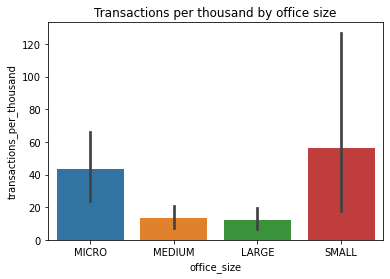

In [97]:
# Let's visualize the per capita transactions for each office size
sns.barplot(x='office_size', y='transactions_per_thousand', data=per_capita_transactions)
plt.title('Transactions per thousand by office size')
plt.show()

## Insights and Recommendations

From our analysis, we have the following key findings:

- Finding: it appears that smaller offices (small and micro) are handling more transactions per thousand people in their service areas than larger offices (medium and large). 

Based on these findings, we can make the following recommendations:

- Recommendation 1: Consider expanding the capacity of small and micro offices, as they are handling a higher number of transactions relative to their population. This could include increasing staff, expanding operating hours, or even enlarging the physical size of these offices
- Recommendation 2: If there are areas served by small and micro offices that have high service demand, investigate the feasibility of opening new offices, especially larger ones, in these areas.

* Time series plots

In [98]:
merged_visit_df['week_day'] = merged_visit_df['welcome_time'].dt.day_name()
merged_visit_df['week_day']

0          Monday
1          Monday
2         Tuesday
3        Thursday
4         Tuesday
          ...    
9906       Friday
9907      Tuesday
9908    Wednesday
9909    Wednesday
9910     Thursday
Name: week_day, Length: 9911, dtype: object

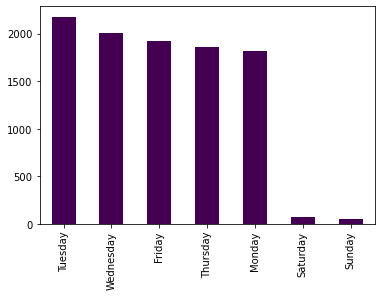

In [99]:
merged_visit_df['week_day'].value_counts().plot(kind='bar',colormap='viridis');

* Tuesday's had the most transactions!

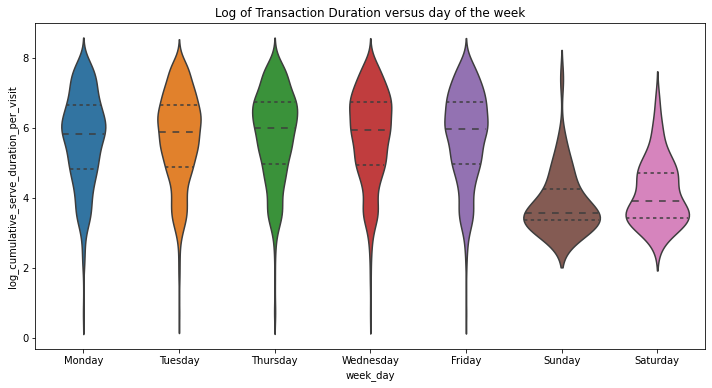

In [100]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='week_day', y='log_cumulative_serve_duration_per_visit', data=merged_visit_df,inner='quartile')
plt.title('Log of Transaction Duration versus day of the week')
plt.show()

* Week of the day looks like has no influence on the service time

* Area wise performance over time

In [101]:
time_stats_by_area = merged_visit_df[time_cols +['client_id','area_name']].groupby(['area_name']).agg(transaction_count = ('client_id','count'),
                                                                                                                                    median_serve_duration_per_service = ('serve_duration_per_service','median'),
                                                                                                                        median_serve_duration_per_visit = ('serve_duration_per_visit','median'),
                                                                                                                        median_service_creation_duration_per_visit = ('service_creation_duration_per_vi','median'),
                                                                                                                        median_prep_duration_per_visit = ('prep_duration_per_visit','median'),
                                                                                                                        median_prep_duration_per_service = ('prep_duration_per_service','median'),
                                                                                                                        median_waiting_duration_per_visit = ('waiting_duration_per_visit','median'),
                                                                                                                        median_waiting_duration_per_service = ('waiting_duration_per_service','median'),
                                                                                                                        median_hold_duration_per_visit = ('hold_duration_per_visit','median'),
                                                                                                                        median_hold_duration_per_service = ('hold_duration_per_service','median'),
                                                                                                                        median_total_service_time = ('total_service_time','median'),
                                                                                                                        median_cumulative_service_time_per_service = ('cumulative_service_time_per_service','median'),
                                                                                                                        median_cumulative_service_time_per_visit = ('cumulative_service_time_per_visit','median')                                                                                                                        
                                                                                                              ).reset_index()

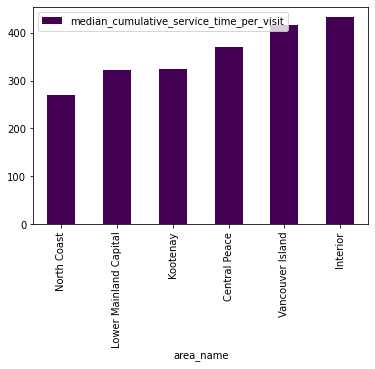

In [102]:
time_stats_by_area.sort_values(by='median_cumulative_service_time_per_visit').plot(x='area_name',y=['median_cumulative_service_time_per_visit'],kind='bar',colormap='viridis');

* Weekly moving average analysis by area

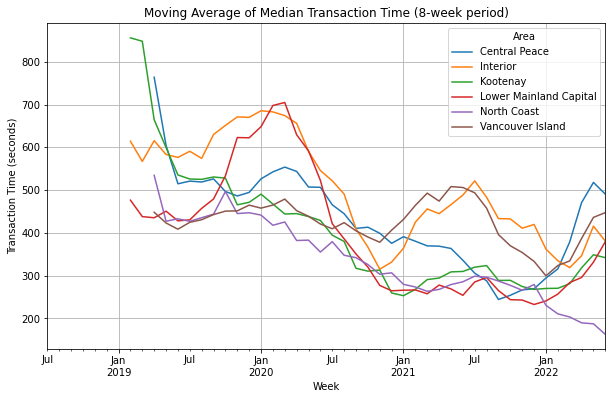

In [103]:
# Calculate the median transaction time per week for each region
median_times_per_week = merged_visit_df.groupby([pd.Grouper(key='date', freq='M'), 'area_name'])['cumulative_service_time_per_visit'].median().unstack()

# Calculate the moving average of the median transaction time over a 3-week period
moving_avg = median_times_per_week.rolling(window=8).mean()

# Create a separate plot for the moving average
moving_avg.plot(kind='line', figsize=(10, 6))

# Customize the moving average plot
plt.title('Moving Average of Median Transaction Time (8-week period)')
plt.xlabel('Week')
plt.ylabel('Transaction Time (seconds)')
plt.legend(title='Area')
plt.grid(True)

# Display the plots
plt.show()

* The transaction times seem to decrease over time across all areas, but in the latest data, there is an uptick

* First nations locations have been downloaded from Canada open government website. Let's find the nearest office to each of the first nations locations.

In [104]:
# Path to the shapefile
shapefile_path = './data/location_data/Premiere_Nation_First_Nation_SHP/Premiere_Nation_First_Nation.shp'

# Read the shapefile into a GeoDataFrame
first_nations_gdf = gpd.read_file(shapefile_path)

In [105]:
first_nations_gdf

,BAND_NBR,BAND_NAME,geometry
0,168,Munsee-Delaware Nation,POINT (-81.46830 42.78799)
1,120,Mississaugas of the Credit,POINT (-80.09515 43.00002)
2,23,Eskasoni,POINT (-60.64555 45.93052)
3,468,Fort McMurray #468 First Nation,POINT (-111.15746 56.41353)
4,461,Mikisew Cree First Nation,POINT (-111.09969 58.75706)
...,...,...,...
632,151,Northwest Angle No.33,POINT (-95.01585 49.36315)
633,397,Ministikwan Lake Cree Nation,POINT (-109.66957 54.05013)
634,601,Westbank First Nation,POINT (-119.60531 49.83982)
635,83,Première Nation des Innus de Nutashkuan,POINT (-61.80242 50.13366)


In [106]:
bc_boundary

,PRUID,DGUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,LANDAREA,geometry
9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544,"MULTIPOLYGON (((3843551.097 2389750.100, 38435..."


In [107]:
# Reproject the First Nations data to match the CRS of BC boundaries
first_nations_gdf = first_nations_gdf.to_crs(bc_boundary.crs)

# Perform a spatial join to determine First Nations within BC
first_nations_bc = gpd.sjoin(first_nations_gdf, bc_boundary, how='inner', op='within')

# Reproject the First Nations data to match the CRS of office gdf
first_nations_reserves = first_nations_bc.to_crs(office_gdf.crs)

# Create a list to store the nearest office name for each First Nation reserve
nearest_office_names = []

# Iterate over First Nations reserves and find the nearest office name
for idx, reserve in first_nations_reserves.iterrows():
    nearest_office = office_gdf.distance(reserve.geometry).idxmin()
    nearest_office_name = office_gdf.loc[nearest_office]['office_name']
    nearest_office_names.append(nearest_office_name)

# Create a DataFrame with First Nations reserves and their nearest office name
nearest_office_df = pd.DataFrame({'First_Nation_Reserve': first_nations_reserves['BAND_NAME'],
                                  'Nearest_Office_Name': nearest_office_names})

# Display the DataFrame
nearest_office_df.head()

C:\Users\vindurth\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-107-c6709db3fca0>:15: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_office = office_gdf.distance(reserve.geometry).idxmin()


,First_Nation_Reserve,Nearest_Office_Name
6,Williams Lake First Nation,Williams Lake
15,Tsartlip,Victoria
21,Boothroyd,Merritt
25,Uchucklesaht,Port Alberni
27,Ditidaht,Port Alberni


In [108]:
first_nations_bc

,BAND_NBR,BAND_NAME,geometry,index_right,PRUID,DGUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,LANDAREA
6,719,Williams Lake First Nation,POINT (4232997.912 2249012.976),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
15,653,Tsartlip,POINT (3959456.891 1950696.370),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
21,700,Boothroyd,POINT (4158257.434 2020054.288),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
25,667,Uchucklesaht,POINT (3882458.395 2049659.679),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
27,662,Ditidaht,POINT (3894272.100 2015864.765),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
...,...,...,...,...,...,...,...,...,...,...,...,...
624,669,Old Massett Village Council,POINT (3772825.503 2780098.431),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
625,649,Nanoose First Nation,POINT (3953017.284 2039608.515),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
627,651,Qualicum First Nation,POINT (3929894.303 2070773.721),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544
629,530,Witset First Nation,POINT (4088282.871 2696590.663),9,59,2021A000259,British Columbia / Colombie-Britannique,British Columbia,Colombie-Britannique,B.C.,C.-B.,920686.5544


In [109]:
nearest_office_df[nearest_office_df['Nearest_Office_Name']=='Vancouver']

,First_Nation_Reserve,Nearest_Office_Name
471,Squamish,Vancouver
491,Musqueam,Vancouver


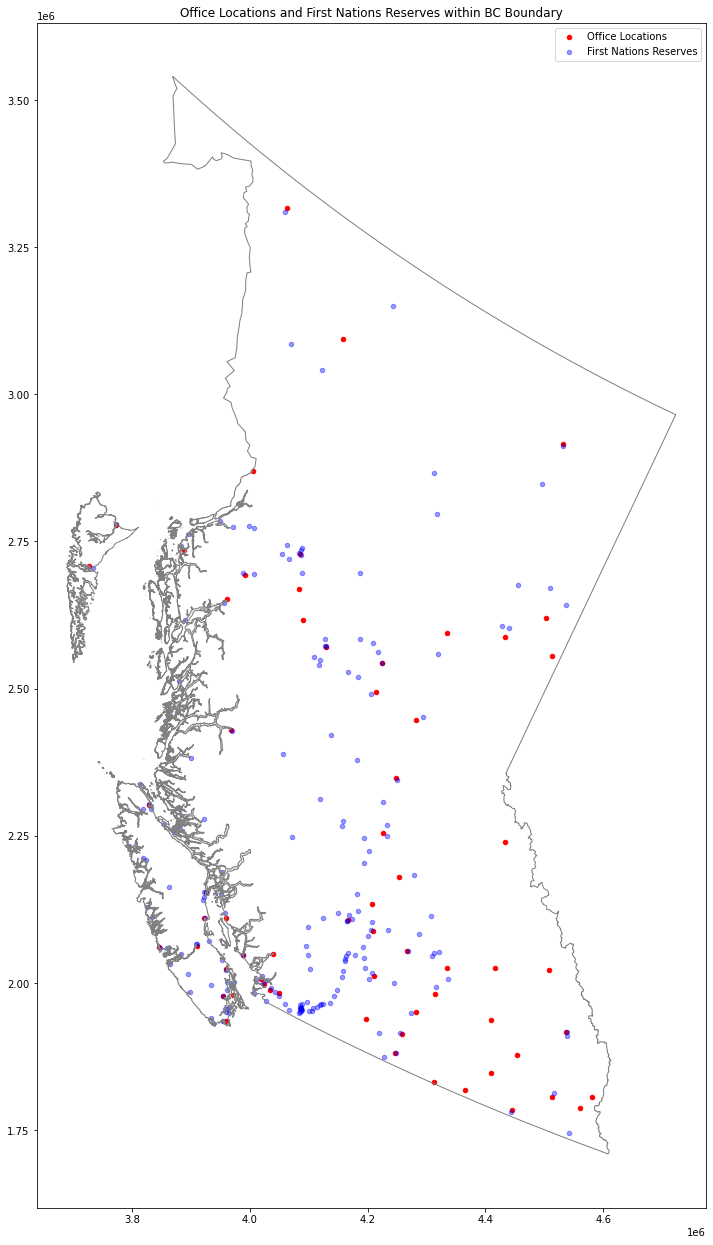

In [110]:
# Reproject all datasets to the CRS of the BC boundary
office_gdf = office_gdf.to_crs(bc_boundary.crs)
first_nations_reserves = first_nations_reserves.to_crs(bc_boundary.crs)


# Plot all the offices, First Nations reserves, and BC boundary
fig, ax = plt.subplots(figsize=(12, 25))
bc_boundary.boundary.plot(ax=ax, color='gray', linewidth=1)
office_gdf.plot(ax=ax, color='red', markersize=20, label='Office Locations')
first_nations_reserves.plot(ax=ax, color='blue', markersize=20, alpha=0.4, label='First Nations Reserves')

plt.title('Office Locations and First Nations Reserves within BC Boundary')
plt.legend()
plt.savefig('./output/first nations within BC.png')
plt.show()

In [111]:
nearest_office_df.groupby('Nearest_Office_Name')['First_Nation_Reserve'].count().sort_values(ascending=False)

Nearest_Office_Name
Chilliwack        24
Port Hardy        12
Ashcroft          10
Victoria           8
Hazelton           8
Campbell River     8
Lillooet           8
Williams Lake      7
Merritt            7
Burns Lake         7
Ucluelet           6
Port Alberni       5
Fort St. James     5
Prince Rupert      4
Terrace            4
Maple Ridge        4
Duncan             4
Salmon Arm         4
Bella Coola        4
Quesnel            4
Kitimat            3
Kamloops           3
Nanaimo            3
Ganges             3
Dease Lake         3
Chetwynd           3
Burnaby            3
Powell River       2
Surrey             2
Vancouver          2
Vanderhoof         2
Squamish           2
Mackenzie          2
Invermere          2
Fort St. John      2
Oliver             2
Fort Nelson        2
Penticton          1
Fernie             1
Atlin              1
Vernon             1
Courtenay          1
Cranbrook          1
Creston            1
Daajing Giids      1
Smithers           1
Stewart       

* Statisics Canada defines a rural area as: 
* *Areas with fewer than 1,000 inhabitants and a population density below 400 people per square kilometre*
* Based on this, from the 2021 cenusus data, the following dataset has been created.


In [112]:
urban_pop = pd.read_csv('./data/urban_population.csv')
urban_pop.head()

,city,city_type,median_age,population_density_per_square_km,pop_2021,is_urban
0,Abbotsford,City,39.2,409.0,153524,1
1,Anmore,Village,45.6,85.6,2356,0
2,Ashcroft,Village,58.4,32.8,1670,0
3,Barriere,District municipality,58.4,164.5,1765,0
4,Belcarra,Village,55.2,124.8,687,0


In [113]:
urban_df = merged_visit_df.merge(urban_pop,on='city',how='inner')

In [114]:
urban_df.shape[0] # So, for this analysis we are only using about 50% of the transaction data!

5456

In [115]:
urban_df.groupby('is_urban')['office_name'].nunique()

is_urban
0    17
1    15
Name: office_name, dtype: int64

In [116]:
urban_df['is_urban'].value_counts()

1    3207
0    2249
Name: is_urban, dtype: int64

In [117]:
transaction_count_by_pop_type = urban_df.groupby(['is_urban','program_id']).agg(transaction_count=('client_id','count')).reset_index()

In [118]:
transaction_count_by_pop_type[transaction_count_by_pop_type['is_urban']==0].sort_values(by=['transaction_count'])

,is_urban,program_id,transaction_count
66,0,MCFD - 004,1
85,0,Other - 011,1
48,0,ICBC - 004,1
101,0,PTAX - 002,1
100,0,Other - 57,1
...,...,...,...
52,0,ICBC - 009,60
51,0,ICBC - 008,110
61,0,ID Verification - 010,255
23,0,Back Office - 021,285


In [119]:
transaction_count_by_pop_type[transaction_count_by_pop_type['is_urban']==1].sort_values(by=['transaction_count'])

,is_urban,program_id,transaction_count
206,1,MCFD - 011,1
226,1,Other - 016,1
222,1,Other - 008,1
165,1,CCII - 001,1
255,1,Redirects - 011,1
...,...,...,...
190,1,ICBC - 009,121
189,1,ICBC - 008,135
160,1,Back Office - 021,311
202,1,ID Verification - 010,422


* Urban locations have more transaction volume but the top program id's remain the similar.

In [121]:
urban_df.groupby('is_urban')['cumulative_service_time_per_visit'].median()

is_urban
0    355.0
1    370.0
Name: cumulative_service_time_per_visit, dtype: float64

* Urban and rural locations have similar service times